# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

<AxesSubplot:>

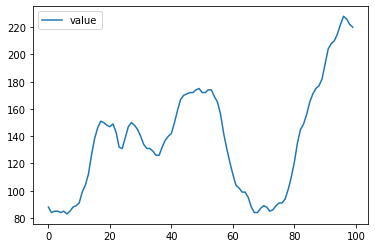

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

df = pd.read_csv('data/wwwusage.csv', names=['value'], header=0)
y = df.value
df.plot()

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [2]:
from statsmodels.tsa.stattools import adfuller
adfuller(y, autolag='AIC')

(-2.4642397172033688,
 0.12441935447109453,
 3,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 444.67104090432554)

The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [3]:
y_diff1 = y.diff().dropna()
#.dropna()
y_diff2 = y_diff1.diff().dropna()

In [4]:
adfuller(y_diff1, autolag='AIC')

(-2.722238490442953,
 0.07026846015272707,
 2,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 438.89606128026)

In [5]:
adfuller(y_diff2, autolag='AIC')

(-9.929762173626015,
 2.843428755547158e-17,
 1,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 438.2804466027877)

We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

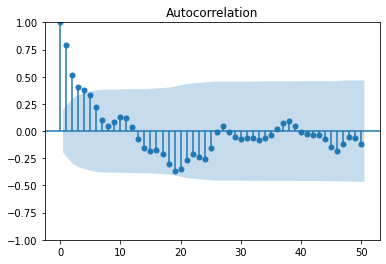

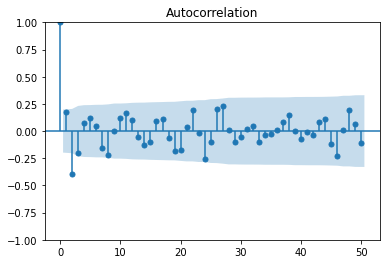

In [6]:
plot_acf(y_diff1,lags = 50)
plot_acf(y_diff2,lags = 50)
plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [7]:
y_diff = y.diff().dropna()

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

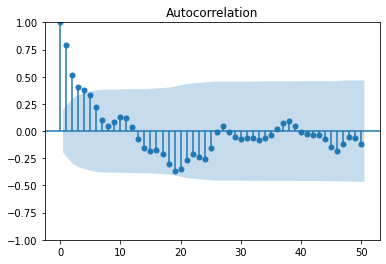

In [8]:
plot_acf(y_diff1,lags = 50);

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

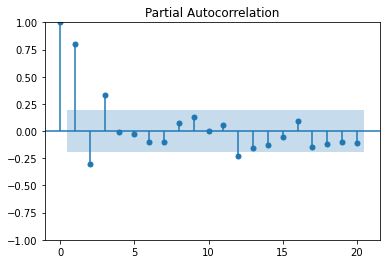

In [9]:
plot_pacf(y_diff1);

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y, order=(1, 1, 2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Tue, 04 Jan 2022   AIC                            516.253
Time:                        23:00:15   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.671      -0.373       0.241
sigma2         9.7898      1.421      6.889      0.000       7.005      12.575
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.98   Prob(JB):                         0.95
Heteroskedasticity (H):               0.63   Skew:                            -0.07
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
model = ARIMA(y, order=(1, 1, 1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Tue, 04 Jan 2022   AIC                            514.300
Time:                        23:00:15   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.000       7.040      12.547
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.86   Prob(JB):                         0.94
Heteroskedasticity (H):               0.63   Skew:                            -0.08
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
model = ARIMA(y, order=(3, 1, 3))
result = model.fit()
result.summary()

C:\Users\fuetu\.virtualenvs\P16_timeseries-TifMbjJX\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -249.034
Date:                Tue, 04 Jan 2022   AIC                            512.068
Time:                        23:00:16   BIC                            530.234
Sample:                             0   HQIC                           519.418
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6819      0.094     17.946      0.000       1.498       1.866
ar.L2         -1.6078      0.117    -13.724      0.000      -1.837      -1.378
ar.L3          0.6790      0.097      6.965      0.000       0.488       0.870
ma.L1         -0.6007      0.337     -1.782      0.075      -1.261       0.060
ma.L2          0.4369      0.444      0.985      0.325      -0.433       1.306
ma.L3          0.5034      0.318      1.584      0.113      -0.120       1.126
sigma2         8.4606      4.772      1.773      0.076      -0.892      17.813
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.98   Prob(JB):                         0.59
Heteroskedasticity (H):               0.51   Skew:                            -0.25
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

### Problematic stuff

In [13]:
type(result)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

In [14]:
import statsmodels
statsmodels.__version__

'0.13.1'

In [15]:
print(result.__getattributs__)

AttributeError: 'ARIMAResults' object has no attribute '__getattributs__'

In [ ]:
result.plot_predict()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

### statsmodels version 0.13.1

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y, order=(3, 1, 3))
result = model.fit()
result.summary()

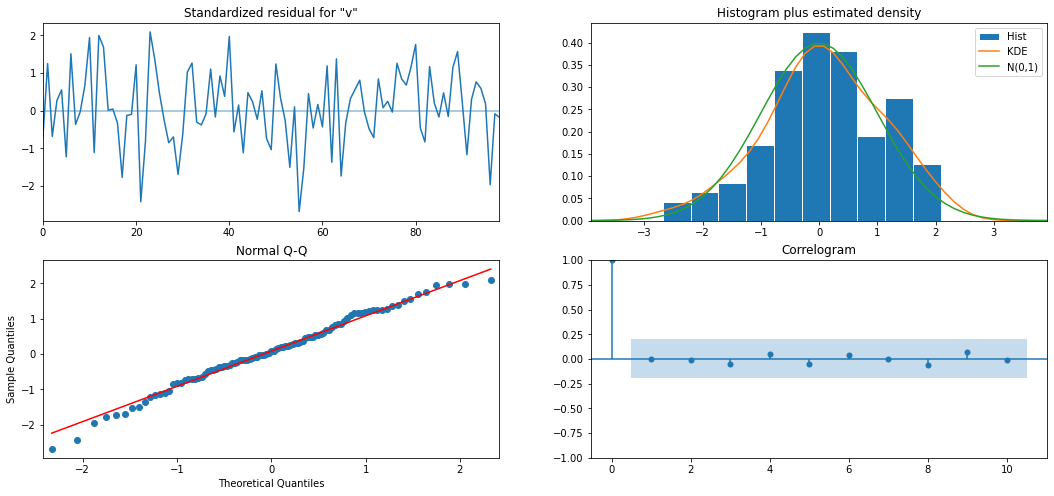

In [30]:
result.plot_diagnostics(figsize=(18,8));

In [19]:
result.specification

{'seasonal_periods': 0,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': (3, 1, 3),
 'seasonal_order': (0, 0, 0, 0),
 'k_diff': 1,
 'k_seasonal_diff': 0,
 'k_ar': 3,
 'k_ma': 3,
 'k_seasonal_ar': 0,
 'k_seasonal_ma': 0,
 'k_ar_params': 3,
 'k_ma_params': 3,
 'trend': 'n',
 'k_trend': 0,
 'k_exog': 0,
 'mle_regression': False,
 'state_regression': False}

In [101]:
predict = result.get_prediction()
predict_ci = predict.conf_int()
predict_val = predict.predicted_mean
# print(predict.prediction_results)
# print(predict.prediction_results.results)
predict_val.drop(0,axis=0,inplace=True)
predict_val

1      88.002346
2      80.769038
3      87.216475
4      83.167169
5      83.303920
         ...    
95    220.261167
96    227.454751
97    231.759332
98    222.250156
99    220.524073
Name: predicted_mean, Length: 99, dtype: float64

In [ ]:
predict_dy = result.get_prediction(dynamic=True)
predict_dy_ci = predict_dy.conf_int()

In [103]:
predict_ci.drop(0,axis=0,inplace=True)
predict_ci

,lower value,upper value
1,76.742819,99.261872
2,74.129867,87.408209
3,80.868626,93.564325
4,77.122312,89.212027
5,77.261335,89.346505
...,...,...
95,214.516994,226.005339
96,221.711251,233.198251
97,226.016659,237.502004
98,216.507520,227.992791


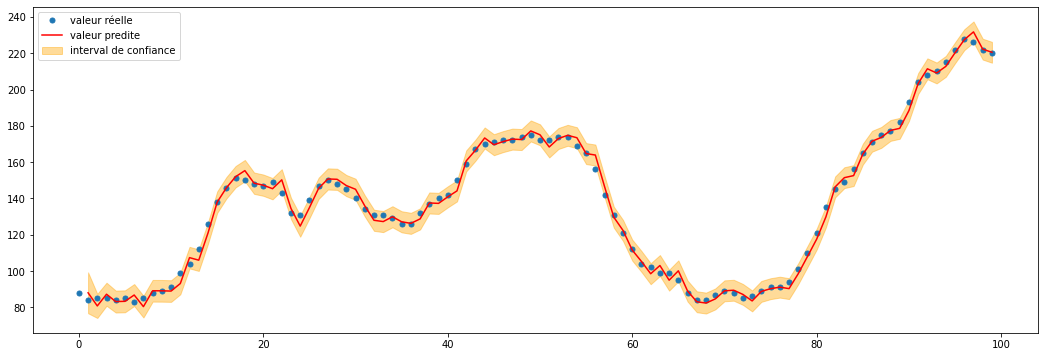

In [113]:
ci = predict_ci
plt.figure(figsize=(18,6))
plt.plot(y,'o', markersize=5, label = 'valeur réelle' )
plt.plot(predict_val,color = 'red', label = 'valeur predite')
plt.fill_between(ci.index,ci['lower value'],ci['upper value'],color='orange',alpha=0.4,label = 'interval de confiance')
# plt.title('evolution and prediction of value during time')
plt.legend(loc='upper left')
plt.show()

In [ ]:
dir(predict.prediction_results)

In [ ]:
dir(predict)

In [ ]:
plt.plot(predict)

### statsmodels version 0.11 

In [ ]:
! pip install statsmodels==0.11

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [ ]:
y[0:85].shape
y[85:].shape

(15,)

In [114]:
y_train = y[0:85]
y_test = y[85:]

In [136]:
model = ARIMA(y_train, order=(3, 1, 3)).fit()
#result.summary()

C:\Users\fuetu\.virtualenvs\P16_timeseries-TifMbjJX\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [ ]:
print(y[85])
model.forecast()

In [141]:
y_test_pred = model.get_forecast(15).predicted_mean
y_test_ci = model.get_forecast(15).conf_int()
y_test_ci

,lower value,upper value
85,157.529013,169.405007
86,153.853926,182.761462
87,148.179115,194.390337
88,142.715350,204.846219
89,136.193504,213.850468
90,130.121048,221.942254
91,124.352151,229.295648
92,118.382231,235.749815
93,113.153023,241.883701
94,107.912952,247.431173


In [ ]:
dir(result.get_forecast())

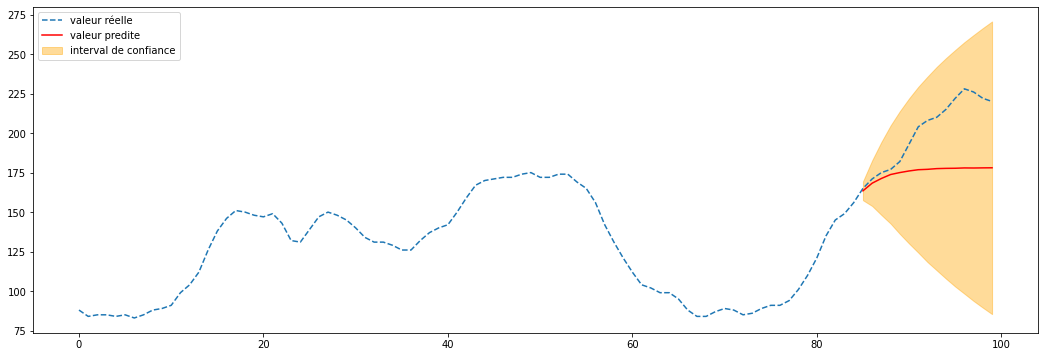

In [143]:
ci = y_test_ci
plt.figure(figsize=(18,6))
plt.plot(y,'--', markersize=5, label = 'valeur réelle' )
plt.plot(y_test_pred,color = 'red', label = 'valeur predite')
plt.fill_between(ci.index,ci['lower value'],ci['upper value'],color='orange',alpha=0.4,label = 'interval de confiance')
# plt.title('evolution and prediction of value during time')
plt.legend(loc='upper left')
plt.show()

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

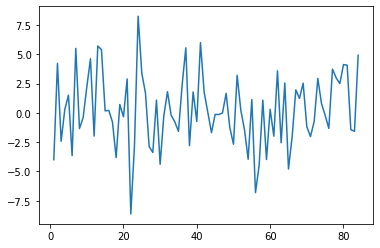

In [145]:
plt.plot(model.resid.drop(0,axis=0))

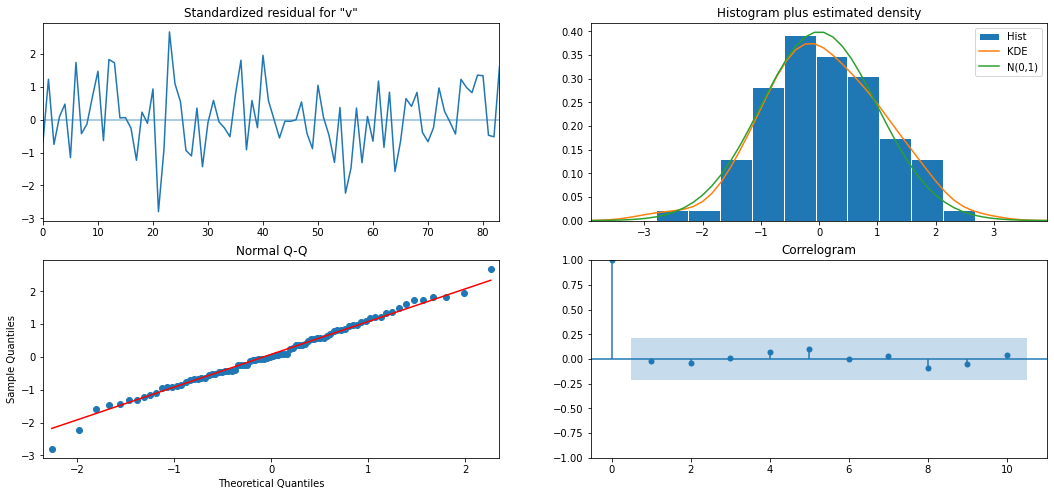

In [146]:
model.plot_diagnostics(figsize=(18,8));

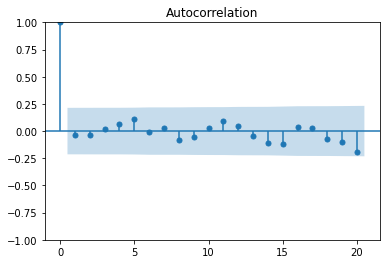

In [148]:
plot_acf(model.resid.drop(0,axis=0));

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [149]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [152]:
forecast_accuracy(y_test_pred,y_test)

{'mape': 0.12143791482854244,
 'me': -26.09277544474982,
 'mae': 26.09277544474982,
 'mpe': -0.12143791482854244,
 'rmse': 31.610176129651943,
 'acf1': 0.87206999635313,
 'corr': 0.8630592362988883,
 'minmax': 0.12143791482854238}

## 4 Grid Search

In [ ]:
!pip install pmdarima
import pmdarima as pm

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [157]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(y, start_p=1, start_q=1,
                             max_p=4, max_q=4,
                             start_P=0,
                             d=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             )


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=515.580, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=627.619, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=530.856, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=548.164, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=630.995, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=517.580, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=517.580, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=519.980, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=523.315, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=518.732, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=514.300, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=549.806, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=529.238, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=516.292, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=516.2

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [229]:
import warnings
warnings.filterwarnings(action='once')

In [160]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [167]:
tscv.split(y)

<generator object TimeSeriesSplit.split at 0x0000021BA9A24BA0>

In [168]:
for train_index, test_index in tscv.split(y):
    print("TRAIN:", train_index, "TEST:", test_index)
    y_train, y_test = y[train_index], y[test_index] 

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51] TEST: [52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67] TEST: [68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65

In [226]:
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    print('mean of results on CV :\n')
    return mean_dict

def make_cv(y,order = (1,1,1),n_split = 5):
    results = []
    tscv = TimeSeriesSplit(n_splits=n_split)
    for train_index, test_index in tscv.split(y):
        y_train, y_test = y[train_index], y[test_index]
        model = ARIMA(y_train, order=order).fit()
        y_test_pred =model.forecast(len(test_index))
        results.append(forecast_accuracy(y_test_pred,y_test))
    # print('mean of results on CV :\n')
    # for key,val in dict_mean(results).items():
    #     print(key ,val)
    return results
        


In [227]:
results = make_cv(y)
dict_mean(results)

mean of results on CV :



{'mape': 0.23224473958959221,
 'me': -10.00761142670413,
 'mae': 32.031304514423326,
 'mpe': -0.02222878415982966,
 'rmse': 37.79992730320067,
 'acf1': 0.8002926494101086,
 'corr': -0.12412215361441903,
 'minmax': 0.19146122176394506}

In [231]:
results = make_cv(y,order=(3, 1, 3))
dict_mean(results)

mean of results on CV :



{'mape': 0.23354071361929804,
 'me': -9.637291676791753,
 'mae': 32.18894410723273,
 'mpe': -0.01903525143501339,
 'rmse': 38.12883196785127,
 'acf1': 0.7950994292057397,
 'corr': -0.1877600069217913,
 'minmax': 0.19177619929056808}

In [181]:
for result in results:
    print(round(result['mae'],2))

7.35
36.25
50.22
22.94
44.18
